In [54]:
##### Combines the MapSPAM data into 1 map on crop production 

import os
import pandas as pd
import geopandas as gpd
import rioxarray as rio
import matplotlib.pyplot as plt
import numpy as np

In [55]:
##### Load data

# Get the current working directory
cd = os.path.dirname(os.getcwd())

# Import data
livestock = rio.open_rasterio(f"{cd}/Data/Raw/FAO_gridded_livestock/GLW4-2020.D-DA.GLEAM3-ALL-LU.tif")

country_boundaries = gpd.read_file("/Users/carinamanitius/Documents/Data/Admin_Boundaries/simple_for_map/World_Countries_Generalized.shp")


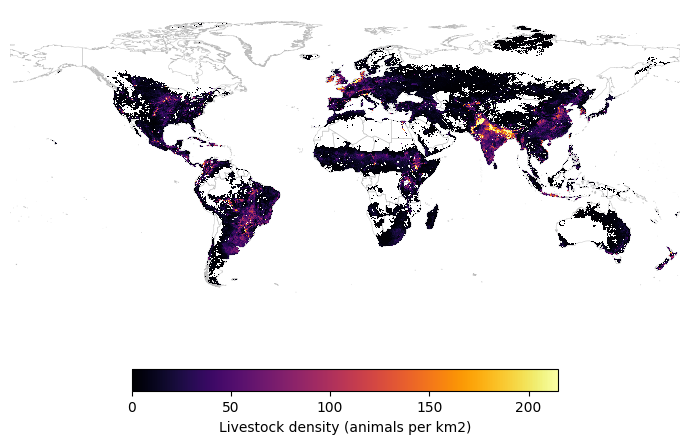

In [56]:
##### Produce global map fo livestock density

# Prepare raster
livestock_plot = livestock.squeeze()
livestock_masked = livestock_plot.where(livestock_plot > 1)
livestock_eq = livestock_masked.rio.reproject(
    "EPSG:8857"
)

# Match CRS
country_boundaries = country_boundaries.to_crs(livestock_masked.rio.crs)

# Create figure
fig, ax = plt.subplots(figsize=(7, 5))

# Country borders underneath (thin, light grey)
country_boundaries.plot(
    ax=ax,
    facecolor="none",
    edgecolor="#bdbdbd",
    linewidth=0.3,
    zorder=1
)

# Raster on top
im = livestock_masked.plot(
    ax=ax,
    cmap="inferno",
    vmin=0,
    vmax=215,
    add_colorbar=False,
    add_labels=False,
    zorder=2
)

# Remove axes and any title
ax.set_axis_off()
ax.set_title("")

# Bottom horizontal colorbar (legend)
cbar = fig.colorbar(
    im,
    ax=ax,
    orientation="horizontal",
    fraction=0.05,
    pad=0.04
)
cbar.set_label("Livestock density (animals per km2)")
cbar.set_ticks([0, 50, 100, 150, 200])

plt.tight_layout()
plt.show()